## Find local ancestry for msprime simulated genotype data

reference code: https://gist.github.com/gtsambos/3165c24aebb50d2ca4b743b25673c413

### Test the code

In [3]:
import tskit
import numpy as np
import msprime # Only used to generate sample datasets for this notebook.
from IPython.display import SVG # Only used to plot trees in this notebook.

### Step1: setting up simulation

In [2]:
# setting up your simulations to work with link_ancestor
# I'll generate a simple example: a demographic history involvin
## Samples from an admixed population
## Generated by admixture of 2 other populations x years ago
pop0 = msprime.PopulationConfiguration(sample_size=3, initial_size = 500)
pop1 = msprime.PopulationConfiguration(sample_size=3, initial_size = 500)

M = np.array([
[0, 0.10],
[0.08, 0]])

ts = msprime.simulate(
        population_configurations = [pop0, pop1],
        demographic_events = [msprime.CensusEvent(time=1000)],
        migration_matrix = M,
        length = 1000,
        random_seed = 31,
        recombination_rate = 1e-7)

Tree on interval: (0.0, 25.49455408600498)


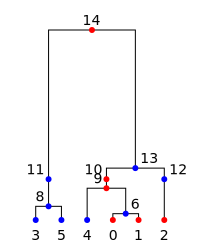

Tree on interval: (25.49455408600498, 1000.0)


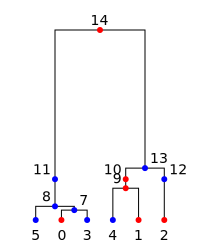

In [5]:
colour_map = {0:"red", 1:"blue"}
node_colours = {u.id: colour_map[u.population] for u in ts.nodes()}
for tree in ts.trees():
    print("Tree on interval:", tree.interval)
#     # The code below will only work in a Jupyter notebook with SVG output enabled.
    display(SVG(tree.draw(node_colours=node_colours, height=250)))

### Step2: Get local ancestry using link_ancestors

#### 1. Choose the "ancestors' that you are interested in

In tree sequence land, this means picking the 'nodes' of the tree sequence that belong to the ancestors of interest. Typically, this will be all of the nodes that exist at a particular generation back in time, or all nodes that belonged to some particular ancestral population of interest.

Suppose you wanted to find local ancestry to all ancestors who were alive 1000 generations ago. You'd select the appropriate nodes like this:

In [9]:
ancestors_1000_gens = np.where(ts.tables.nodes.time == 1000)[0]

print(ancestors_1000_gens)

[10 11 12]


Suppose you want to find local ancestry from all ancestors at time 1000 belonging to population 1. You'd find nodes like this:

In [7]:
all_ancestors = np.where(ts.tables.nodes.time == 1000)
all_pop1 = np.where(ts.tables.nodes.population == 1)
ancestors_pop1 = np.intersect1d(all_ancestors, all_pop1)

print(ancestors_pop1)

[11 12]


#### 2. Apply link_ancestors using the set of ancestors you just chose

In [10]:
ancestrytable_1000gens = ts.tables.link_ancestors(
    samples=ts.samples(), ancestors=ancestors_1000_gens)

print(ancestrytable_1000gens)

id	left		right		parent	child
0	0.00000000	25.49455409	10	0
1	0.00000000	1000.00000000	10	1
2	0.00000000	1000.00000000	10	4
3	25.49455409	1000.00000000	11	0
4	0.00000000	1000.00000000	11	3
5	0.00000000	1000.00000000	11	5
6	0.00000000	1000.00000000	12	2


Note that every number in the 'parent' table above is one of the nodes in ancestors_1000_gens. This is essntially what link_ancestors does -- it shows you directly which of your samples descend from which ancestors.

In [11]:
ancestrytable_pop1 = ts.tables.link_ancestors(
    samples=ts.samples(), ancestors=ancestors_pop1)

print(ancestrytable_pop1)

id	left		right		parent	child
0	25.49455409	1000.00000000	11	0
1	0.00000000	1000.00000000	11	3
2	0.00000000	1000.00000000	11	5
3	0.00000000	1000.00000000	12	2


#### 3. Replace the parent nodes with their population label.

In [12]:
nodeTable = ts.tables.nodes

In [13]:
def get_population_id(node, ts):
    return ts.tables.nodes.population[node]

In [14]:
import pandas as pd

ancestry_table = pd.DataFrame(
    data = {
        'left': ancestrytable_1000gens.left,
        'right': ancestrytable_1000gens.right,
        'populations': [get_population_id(u, ts) for u in ancestrytable_1000gens.parent],
        'child': ancestrytable_1000gens.child
    }
)

print(ancestry_table)

        left        right  populations  child
0   0.000000    25.494554            0      0
1   0.000000  1000.000000            0      1
2   0.000000  1000.000000            0      4
3  25.494554  1000.000000            1      0
4   0.000000  1000.000000            1      3
5   0.000000  1000.000000            1      5
6   0.000000  1000.000000            1      2


### Apply to my model

#### Model 1: 400 hap random mating model:

In [1]:
import msprime, sys
from math import log
from math import exp

#seed = int(sys.argv[1]) # input the seed
seed=1
mu=1.25e-8 # mutation rate per bp
rho=1e-8 # recombination rate per bp
#nbp=1e8 # generate 100Mb
nbp=1e7 # generate 10Mb
N0=7310 # initial population size
Thum=5920 # time (gens) of advent of modern humans
Naf=14474 # size of african population
Tooa=2040 # number of generations back to Out of Africa
Nb=1861 # size of out of africa population
mafb=1.5e-4 # migration rate Africa and Out-of-Afica
Teu=920 # number generations back to Asia-Euroupe split
Neu=1032; Nas=554 # bottleneck population sizes
mafeu=2.5e-5;mafas=7.8e-6;meuas=3.11e-5 #mig.rates
reu=0.0038 #growth rate per generation in Europe
ras=0.0048 #growth rate per generation in Asia
Tadmix=16 # time of admixture
Nadmix=30000 # initial size of admixed population
radmix=.05 # growth rate of admixed population
Tcencus=17

# pop0 is Africa, pop1 is Europe,  pop2 is admixed
refsamplesize=100
#admsamplesize=1000 #sample size of admixted pop
admsamplesize=400
pop_config = [
    msprime.PopulationConfiguration(sample_size=refsamplesize, initial_size=Naf), #growth_rate=0.0),
    msprime.PopulationConfiguration(sample_size=refsamplesize, initial_size=Neu*exp(reu*Teu)), #growth_rate=reu),
    msprime.PopulationConfiguration(sample_size=admsamplesize, initial_size=Nadmix*exp(radmix*Tadmix), )]#growth_rate=radmix)]
mig_mat=[
    [0,mafeu,0],
    [mafeu,0,0],
    [0,0,0]]

# Admixture event, 0.76517 Africa, rest Europe
# change the AFR prop according to the 10deme model avg anc
admixture_event = [
    msprime.MigrationRateChange(time=Tadmix, rate=0.0), #newly added, change the migration rate to 0
    msprime.MassMigration(time=Tadmix, source=2, destination=0, proportion=0.76517), # African came to America        
    msprime.MassMigration(time=Tadmix+0.0001, source=2, destination=1, proportion=1.0)] # European came to America

# cencus events
census_event = [
    msprime.CensusEvent(time=Tcencus)
]

# Out of Africa event
ooa_event = [
    msprime.MigrationRateChange(time=Tooa, rate=0.0),
    msprime.MassMigration(time=Tooa+0.0001, source=1, destination=0, proportion=1.0)
]

# initial population size
init_event=[msprime.PopulationParametersChange(time=Thum, initial_size=N0, population_id=0)]

#events = admixture_event + eu_event + ooa_event + init_event
events = admixture_event + census_event + ooa_event + init_event

ts = msprime.simulate(
    population_configurations=pop_config,
    migration_matrix=mig_mat,
    demographic_events=events,
    length=nbp,
    recombination_rate=rho, 
    mutation_rate=mu,
    #record_migrations=True, # newly added, Needed for tracking segments.
    random_seed=seed)

#export to diploid to validate simulated global anc
filename=f'AA_10Mb_random_400hap_chr{seed}.vcf'
n_dip_indv = int(ts.num_samples / 2)
indv_names = [f"AA_{str(i)}indv" for i in range(n_dip_indv)]
with open(filename, "w") as vcf_file:
    ts.write_vcf(vcf_file, ploidy=2, contig_id=str(seed), individual_names=indv_names)



In [4]:
# get local ancestry for 400hap model
# select nodes that are 17 generations ago
ancestors_Tcencus_gens = np.where(ts.tables.nodes.time == Tcencus)[0]
print(ancestors_Tcencus_gens)


[ 653  654  655 ... 2282 2283 2284]


In [5]:
# find local ancestry from all ancestors at time 17 belonging to population 1
all_ancestors = np.where(ts.tables.nodes.time == Tcencus)
all_pop1 = np.where(ts.tables.nodes.population == 1)
ancestors_pop1 = np.intersect1d(all_ancestors, all_pop1)
print(ancestors_pop1)

[1786 1787 1788 1789 1790 1791 1792 1793 1794 1795 1796 1797 1798 1799
 1800 1801 1802 1803 1804 1805 1806 1807 1808 1809 1810 1811 1812 1813
 1814 1815 1816 1817 1818 1819 1820 1821 1822 1823 1824 1825 1826 1827
 1828 1829 1830 1831 1832 1833 1834 1835 1836 1837 1838 1839 1840 1841
 1842 1843 1844 1845 1846 1847 1848 1849 1850 1851 1852 1853 1854 1855
 1856 1857 1858 1859 1860 1861 1862 1863 1864 1865 1866 1867 1868 1869
 1870 1871 1872 1873 1874 1875 1876 1877 1878 1879 1880 1881 1882 1883
 1884 1885 1886 1887 1888 1889 1890 1891 1892 1893 1894 1895 1896 1897
 1898 1899 1900 1901 1902 1903 1904 1905 1906 1907 1908 1909 1910 1911
 1912 1913 1914 1915 1916 1917 1918 1919 1920 1921 1922 1923 1924 1925
 1926 1927 1928 1929 1930 1931 1932 1933 1934 1935 1936 1937 1938 1939
 1940 1941 1942 1943 1944 1945 1946 1947 1948 1949 1950 1951 1952 1953
 1954 1955 1956 1957 1958 1959 1960 1961 1962 1963 1964 1965 1966 1967
 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981
 1982 

In [6]:
# which of your samples descend from which ancestors
ancestrytable_Tcencus_gens = ts.tables.link_ancestors(
    samples=ts.samples(), ancestors=ancestors_Tcencus_gens)

print(ancestrytable_Tcencus_gens)

id	left		right		parent	child
0	4339562.37843716	7027628.28139300	653	325
1	7027628.28139300	8058363.58295250	654	325
2	7027628.28139300	8058363.58295250	654	499
3	8058363.58295250	10000000.00000000	655	499
4	7801472.89340419	10000000.00000000	656	241
5	0.00000000	6736314.13996599	657	71
6	6736314.13996599	10000000.00000000	658	71
7	6736314.13996599	10000000.00000000	658	311
8	922492.47499800	1126746.94534548	659	352
9	9582116.27313451	10000000.00000000	660	482
10	4471332.60184697	5019120.59612086	661	275
11	3614308.65563785	10000000.00000000	662	485
12	0.00000000	6726486.68911459	663	506
13	6726486.68911459	9552587.66411631	664	90
14	6726486.68911459	9552587.66411631	664	506
15	9552587.66411631	10000000.00000000	665	90
16	5012181.08577006	6899822.44439885	666	542
17	6899822.44439885	8714281.11538158	667	207
18	6899822.44439885	8714281.11538158	667	542
19	8714281.11538158	10000000.00000000	668	542
20	1235474.77676428	7446265.55066702	669	568
21	7446265.55066702	8205600.07081497	670	268


In [4]:
# replace the parent to population label
nodeTable = ts.tables.nodes
def get_population_id(node, ts):
    return ts.tables.nodes.population[node]
import pandas as pd

ancestry_table = pd.DataFrame(
    data = {
        'left': ancestrytable_Tcencus_gens.left,
        'right': ancestrytable_Tcencus_gens.right,
        'populations': [get_population_id(u, ts) for u in ancestrytable_Tcencus_gens.parent],
        'child': ancestrytable_Tcencus_gens.child
    }
)

ancestry_table.to_csv(f'loc_anc_chr{seed}.txt', sep='\t', encoding='utf-8', index=False)

NameError: name 'ancestrytable_Tcencus_gens' is not defined

In [5]:
import tskit
import numpy as np
import msprime 
# write a function to do this:
def get_population_id(node, ts):
    return ts.tables.nodes.population[node]

def local_ancestry(Tcencus, ts, seed):
    # select nodes that are Tcencus generations ago
    ancestors_Tcencus_gens = np.where(ts.tables.nodes.time == Tcencus)[0]
    # which of your samples descend from which ancestors
    ancestrytable_Tcencus_gens = ts.tables.link_ancestors(
    samples=ts.samples(), ancestors=ancestors_Tcencus_gens)
    # replace the parent to population label
    #nodeTable = ts.tables.nodes
    import pandas as pd
    ancestry_table = pd.DataFrame(
        data = {
            'left': ancestrytable_Tcencus_gens.left,
            'right': ancestrytable_Tcencus_gens.right,
            'populations': [get_population_id(u, ts) for u in ancestrytable_Tcencus_gens.parent],
            'child': ancestrytable_Tcencus_gens.child
        }
    )
    #return ancestry_table
    # output the ancestry table to a file
    ancestry_table.to_csv(f'loc_anc_chr{seed}.txt', sep='\t', encoding='utf-8', index=False)

In [1]:
local_ancestry(Tcencus, ts)

NameError: name 'local_ancestry' is not defined

In [ ]:
import msprime, sys
from math import log
from math import exp

#seed = int(sys.argv[1]) # input the seed
seed=1
mu=1.25e-8 # mutation rate per bp
rho=1e-8 # recombination rate per bp
nbp=1e8 # generate 100Mb
#nbp=1e7 # generate 10Mb
N0=7310 # initial population size
Thum=5920 # time (gens) of advent of modern humans
Naf=14474 # size of african population
Tooa=2040 # number of generations back to Out of Africa
Nb=1861 # size of out of africa population
mafb=1.5e-4 # migration rate Africa and Out-of-Afica
Teu=920 # number generations back to Asia-Euroupe split
Neu=1032; Nas=554 # bottleneck population sizes
mafeu=2.5e-5;mafas=7.8e-6;meuas=3.11e-5 #mig.rates
reu=0.0038 #growth rate per generation in Europe
ras=0.0048 #growth rate per generation in Asia
Tadmix=16 # time of admixture
Nadmix=30000 # initial size of admixed population
radmix=.05 # growth rate of admixed population
Tcencus=17

# pop0 is Africa, pop1 is Europe,  pop2 is admixed
refsamplesize=100
#admsamplesize=1000 #sample size of admixted pop
admsamplesize=400
pop_config = [
    msprime.PopulationConfiguration(sample_size=refsamplesize, initial_size=Naf), #growth_rate=0.0),
    msprime.PopulationConfiguration(sample_size=refsamplesize, initial_size=Neu*exp(reu*Teu)), #growth_rate=reu),
    msprime.PopulationConfiguration(sample_size=admsamplesize, initial_size=Nadmix*exp(radmix*Tadmix), )]#growth_rate=radmix)]
mig_mat=[
    [0,mafeu,0],
    [mafeu,0,0],
    [0,0,0]]

# Admixture event, 0.76517 Africa, rest Europe
# change the AFR prop according to the 10deme model avg anc
admixture_event = [
    msprime.MigrationRateChange(time=Tadmix, rate=0.0), #newly added, change the migration rate to 0
    msprime.MassMigration(time=Tadmix, source=2, destination=0, proportion=0.76517), # African came to America        
    msprime.MassMigration(time=Tadmix+0.0001, source=2, destination=1, proportion=1.0)] # European came to America

# cencus events
census_event = [
    msprime.CensusEvent(time=Tcencus)
]

# Out of Africa event
ooa_event = [
    msprime.MigrationRateChange(time=Tooa, rate=0.0),
    msprime.MassMigration(time=Tooa+0.0001, source=1, destination=0, proportion=1.0)
]

# initial population size
init_event=[msprime.PopulationParametersChange(time=Thum, initial_size=N0, population_id=0)]

#events = admixture_event + eu_event + ooa_event + init_event
events = admixture_event + census_event + ooa_event + init_event

ts = msprime.simulate(
    population_configurations=pop_config,
    migration_matrix=mig_mat,
    demographic_events=events,
    length=nbp,
    recombination_rate=rho, 
    mutation_rate=mu,
    #record_migrations=True, # newly added, Needed for tracking segments.
    random_seed=seed)

#export to diploid to validate simulated global anc
filename=f'AA_10Mb_random_400hap_chr{seed}.vcf'
n_dip_indv = int(ts.num_samples / 2)
indv_names = [f"AA_{str(i)}indv" for i in range(n_dip_indv)]
with open(filename, "w") as vcf_file:
    ts.write_vcf(vcf_file, ploidy=2, contig_id=str(seed), individual_names=indv_names)


import tskit
import numpy as np
import msprime 
# write a function to do this:
def get_population_id(node, ts):
    return ts.tables.nodes.population[node]

def local_ancestry(Tcencus, ts, seed):
    # select nodes that are Tcencus generations ago
    ancestors_Tcencus_gens = np.where(ts.tables.nodes.time == Tcencus)[0]
    # which of your samples descend from which ancestors
    ancestrytable_Tcencus_gens = ts.tables.link_ancestors(
    samples=ts.samples(), ancestors=ancestors_Tcencus_gens)
    # replace the parent to population label
    #nodeTable = ts.tables.nodes
    import pandas as pd
    ancestry_table = pd.DataFrame(
        data = {
            'left': ancestrytable_Tcencus_gens.left,
            'right': ancestrytable_Tcencus_gens.right,
            'populations': [get_population_id(u, ts) for u in ancestrytable_Tcencus_gens.parent],
            'child': ancestrytable_Tcencus_gens.child
        }
    )
    #return ancestry_table
    # output the ancestry table to a file
    ancestry_table.to_csv(f'loc_anc_chr{seed}.txt', sep='\t', encoding='utf-8', index=False)
local_ancestry(Tcencus, ts, seed)

### Model 2: 10,000 hap random mating model:

In [26]:
import msprime, sys
from math import log
from math import exp

#seed = int(sys.argv[1]) # input the seed
seed=1
mu=1.25e-8 # mutation rate per bp
rho=1e-8 # recombination rate per bp
#nbp=1e8 # generate 100Mb
nbp=1e7 # generate 10Mb
N0=7310 # initial population size
Thum=5920 # time (gens) of advent of modern humans
Naf=14474 # size of african population
Tooa=2040 # number of generations back to Out of Africa
Nb=1861 # size of out of africa population
mafb=1.5e-4 # migration rate Africa and Out-of-Afica
Teu=920 # number generations back to Asia-Euroupe split
Neu=1032; Nas=554 # bottleneck population sizes
mafeu=2.5e-5;mafas=7.8e-6;meuas=3.11e-5 #mig.rates
reu=0.0038 #growth rate per generation in Europe
ras=0.0048 #growth rate per generation in Asia
Tadmix=16 # time of admixture
Nadmix=30000 # initial size of admixed population
radmix=.05 # growth rate of admixed population
Tcencus=17

# pop0 is Africa, pop1 is Europe,  pop2 is admixed
refsamplesize=100
#admsamplesize=1000 #sample size of admixted pop
admsamplesize=20000
pop_config = [
    msprime.PopulationConfiguration(sample_size=refsamplesize, initial_size=Naf), #growth_rate=0.0),
    msprime.PopulationConfiguration(sample_size=refsamplesize, initial_size=Neu*exp(reu*Teu)), #growth_rate=reu),
    msprime.PopulationConfiguration(sample_size=admsamplesize, initial_size=Nadmix*exp(radmix*Tadmix), )]#growth_rate=radmix)]
mig_mat=[
    [0,mafeu,0],
    [mafeu,0,0],
    [0,0,0]]

# Admixture event, 0.76517 Africa, rest Europe
# change the AFR prop according to the 10deme model avg anc
admixture_event = [
    msprime.MigrationRateChange(time=Tadmix, rate=0.0), #newly added, change the migration rate to 0
    msprime.MassMigration(time=Tadmix, source=2, destination=0, proportion=0.76517), # African came to America        
    msprime.MassMigration(time=Tadmix+0.0001, source=2, destination=1, proportion=1.0)] # European came to America

# cencus events
census_event = [
    msprime.CensusEvent(time=Tcencus)
]

# Out of Africa event
ooa_event = [
    msprime.MigrationRateChange(time=Tooa, rate=0.0),
    msprime.MassMigration(time=Tooa+0.0001, source=1, destination=0, proportion=1.0)
]

# initial population size
init_event=[msprime.PopulationParametersChange(time=Thum, initial_size=N0, population_id=0)]

#events = admixture_event + eu_event + ooa_event + init_event
events = admixture_event + census_event + ooa_event + init_event

ts = msprime.simulate(
    population_configurations=pop_config,
    migration_matrix=mig_mat,
    demographic_events=events,
    length=nbp,
    recombination_rate=rho, 
    mutation_rate=mu,
    #record_migrations=True, # newly added, Needed for tracking segments.
    random_seed=seed)

#export to diploid to validate simulated global anc
filename=f'AA_10Mb_random_20000hap_chr{seed}.vcf'
n_dip_indv = int(ts.num_samples / 2)
indv_names = [f"AA_{str(i)}indv" for i in range(n_dip_indv)]
with open(filename, "w") as vcf_file:
    ts.write_vcf(vcf_file, ploidy=2, contig_id=str(seed), individual_names=indv_names)

In [27]:
import tskit
import numpy as np
import msprime 
# write a function to do this:
def get_population_id(node, ts):
    return ts.tables.nodes.population[node]

def local_ancestry(Tcencus, ts):
    # select nodes that are Tcencus generations ago
    ancestors_Tcencus_gens = np.where(ts.tables.nodes.time == Tcencus)[0]
    # which of your samples descend from which ancestors
    ancestrytable_Tcencus_gens = ts.tables.link_ancestors(
    samples=ts.samples(), ancestors=ancestors_Tcencus_gens)
    # replace the parent to population label
    #nodeTable = ts.tables.nodes
    import pandas as pd
    ancestry_table = pd.DataFrame(
        data = {
            'left': ancestrytable_Tcencus_gens.left,
            'right': ancestrytable_Tcencus_gens.right,
            'populations': [get_population_id(u, ts) for u in ancestrytable_Tcencus_gens.parent],
            'child': ancestrytable_Tcencus_gens.child
        }
    )
    #return ancestry_table
    # output the ancestry table to a file
    ancestry_table.to_csv("loc_anc.txt", sep='\t', encoding='utf-8', index=False)

In [ ]:
local_ancestry(Tcencus, ts)

### Compare the local_to_global and ADMIXTURE global ancestry

#### Step1: calculate the local to global ancestry from the result file

In [23]:
import pandas as pd
import numpy as np
# load the local ancestry file
df=pd.read_csv("loc_anc_chr1.txt", delimiter='\t') # practice with the small one

#extract poulation 0:AFR only and sort by child
df0=df.loc[df['populations'] == 0].sort_values('child')

# create a new column to store the subtraction of right-left
df0['subtraction']=df0["right"]-df0["left"]

# merge child with same number
df1=df0[["child", "subtraction"]]
aggregation_functions = {'subtraction': 'sum'}
df2=df1.groupby(df1['child']).aggregate(aggregation_functions)

# add child that missing in between
n=20200 #lagest index number
df3=df2.reindex(range(n+1), fill_value= '0')

# calculate the percentage
df3=df3.apply(pd.to_numeric, errors='coerce') #convert to numeric to calculate
nbp=1e7
df3['percentage']=df3['subtraction']/nbp
df4=df3[["percentage"]]

df4.to_csv("loc_anc_to_global_hap.txt", sep='\t', encoding='utf-8', index=True)
# calculate global ancestry for every 2 haplotypes
df5=df4.groupby(np.arange(len(df4))//2).mean()

# write to a file
df5.to_csv("loc_anc_to_global.txt", sep='\t', encoding='utf-8', index=True)

#### Step2: plot local_to_global vs ADMIXTURE global ancestry

In [4]:
import pandas as pd
import numpy as np
# load files
loc_to_glo=pd.read_csv("loc_anc_to_global.txt", delimiter='\t')
admixture_glo=pd.read_csv("AA_10Mb_random_20000hap_chr1_AT_maf0.05_pruned.2.Q", delimiter=' ', header=None)

# combine 2 files together
df=loc_to_glo.merge(admixture_glo, left_index=True, right_index=True)
df.columns = ['id', 'loc_to_glo', 'EUR', 'AFR']
# see admix ppl only
df=df.loc[df['id']>99]
df

,id,loc_to_glo,EUR,AFR
100,100,1.000000,0.057803,0.942197
101,101,1.000000,0.248699,0.751301
102,102,0.946903,0.299337,0.700663
103,103,0.766311,0.378327,0.621673
104,104,0.939233,0.282878,0.717122
...,...,...,...,...
10095,10095,0.942970,0.160343,0.839657
10096,10096,1.000000,0.108155,0.891845
10097,10097,0.733297,0.443638,0.556362
10098,10098,0.822533,0.216704,0.783296


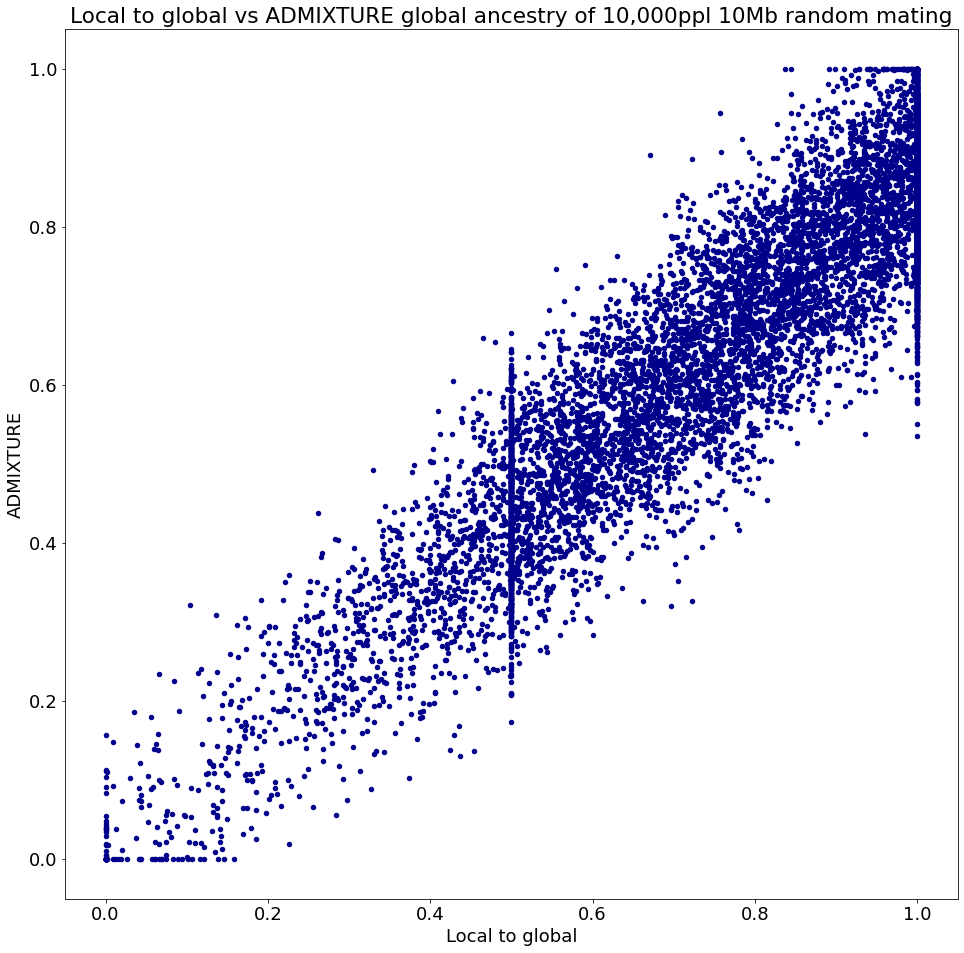

In [3]:
# plot local to global percentage against admixture global 1
import matplotlib.pyplot as plt
p=df.plot.scatter(x='loc_to_glo', y='AFR', c='DarkBlue')
# Add title and axis names
plt.title('Local to global vs ADMIXTURE global ancestry of 10,000ppl 10Mb random mating')
plt.xlabel('Local to global')
plt.ylabel('ADMIXTURE')
# change figure size
from IPython.core.pylabtools import figsize
figsize(16, 16)
# change font size
plt.rcParams.update({'font.size': 18})
# Show graph
#plt.show()
# output this figure
plt.savefig("local_to_global.png")

In [5]:
# check the local-to-global=0.5 line, who are they?
df.loc[df['loc_to_glo']==0.5]


,id,loc_to_glo,EUR,AFR
106,106,0.5,0.536849,0.463151
123,123,0.5,0.618018,0.381982
153,153,0.5,0.397485,0.602515
159,159,0.5,0.553508,0.446492
165,165,0.5,0.429156,0.570844
...,...,...,...,...
10047,10047,0.5,0.525719,0.474281
10050,10050,0.5,0.596635,0.403365
10083,10083,0.5,0.519924,0.480076
10085,10085,0.5,0.528973,0.471027


In [13]:
import pandas as pd
import numpy as np
# load the local ancestry file
df=pd.read_csv("loc_anc_chr1.txt", delimiter='\t') # practice with the small one

#extract poulation 0:AFR only and sort by child
df0=df.loc[df['populations'] == 0].sort_values('child')

# create a new column to store the subtraction of right-left
df0['subtraction']=df0["right"]-df0["left"]

# merge child with same number
df1=df0[["child", "subtraction"]]
aggregation_functions = {'subtraction': 'sum'}
df2=df1.groupby(df1['child']).aggregate(aggregation_functions)

# add child that missing in between
n=20200 #lagest index number
df3=df2.reindex(range(n+1), fill_value= '0')

# calculate the percentage
df3=df3.apply(pd.to_numeric, errors='coerce') #convert to numeric to calculate
nbp=1e7
df3['percentage']=df3['subtraction']/nbp
df4=df3[["percentage"]]

# calculate global ancestry for every 2 haplotypes
#df5=df4.groupby(np.arange(len(df4))//2).mean()
df5=df4.set_index(np.arange(len(df4)) // 2).mean(level=0)
df5.loc[df5['percentage']==0.5] # using np.arrange get the similar result

,percentage
106,0.5
123,0.5
153,0.5
159,0.5
165,0.5
...,...
10047,0.5
10050,0.5
10083,0.5
10085,0.5
